In [70]:
import math
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import scipy.signal as signal
import matplotlib.pyplot as plt

import plotly
from scipy.fftpack import ifft, fft
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [396]:
class session():
    # An object for storing data and metadata for one session of EEG recording
    def __init__(self, filename):
        self.f = filename
        
    def get_data(self, type='OpenBCI', fix=['OpenBCI-col_names']):
        # Create a pandas dataframe with channel data (data_chns)
        # fix:
        #   - "OpenBCI-col_names" - removes spaces from column names and makes channel number's 1-indexed
        if type == 'OpenBCI':
            f = open(self.f)
            self.meta = [f.readline() for i in range(4)]
            self.n_chns = int(self.meta[1][22:])
            self.fs = int(self.meta[2][15:18]) # sample rate

            self.data_chns = pd.read_csv(self.f, skiprows=[0,1,2,3])
            self.data_chns = self.data_chns.drop(columns=['Sample Index'])
            
            if 'OpenBCI-col_names' in fix:
                for i in range(self.n_chns):
                    self.data_chns = self.data_chns.rename(columns={self.data_chns.keys()[i]:'eeg_channel_'+str(i+1)})
            
            if 'Time' not in self.data_chns.keys():
                self.data_chns.reset_index(inplace=True)
                self.data_chns = self.data_chns.rename(columns={'index':'Time'})
                self.data_chns['Time'] = self.data_chns['Time'].divide(self.fs)
                    
    def crop_data(self, upto=-1, after=-1):
        # Crop the data upto or after a certain time in seconds
        if upto > 0:
            self.data_chns = self.data_chns.query('Time>=@upto')
            print('Removed data upto ' + str(upto) + ' seconds.\n')
        if after > 0:
            self.data_chns = self.data_chns.query('Time<=@after')
            print('Removed data after ' + str(upto) + ' seconds.\n')
    
    def make_fft(self):
        timestep = 1/self.fs
        self.fft = df()
        self.fft['Frequency'] = np.fft.fftfreq(len(self.data_chns))
        self.fft['Frequency'] = np.fft.fftshift(self.fft['Frequency'])
        self.fft['Frequency'] = self.fft['Frequency'].div(timestep)
#         self.fft['Frequency'] = np.fft.fftfreq(len(self.data_chns), d=timestep, Fs=self.fs)
        for i in range(self.n_chns):
#             self.fft['eeg_channel_'+str(i+1)] = np.square(np.abs(np.fft.rfft(self.data_chns['eeg_channel_'+str(i+1)])))
            self.fft['eeg_channel_'+str(i+1)] = np.fft.fft(self.data_chns['eeg_channel_'+str(i+1)], norm='ortho')
            self.fft['eeg_channel_'+str(i+1)] = np.abs(self.fft['eeg_channel_'+str(i+1)])**2

    
    def plot(self, ver='', chns=[]):
        # Plot the data in different helpful ways
        if ver == 'pick-channels':
            fig = go.Figure(layout=go.Layout(title=go.layout.Title(text=str(len(chns)) + ' EEG Channels')
                        ))
            
            if len(chns) == 0:
                chns = range(1, self.n_chns + 1)
                print(chns)
            for i in range(len(chns)):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'],
                                            y=self.data_chns['eeg_channel_'+str(chns[i])],
                                            mode='lines',
                                            name='EEG Ch.'+str(chns[i])))
            fig.show()

        if ver == 'all-chns-in-one':
            fig = go.Figure()
            for i in range(self.n_chns):
                fig.add_trace(go.Scatter(x=self.data_chns['Time'], y=self.data_chns['eeg_channel_'+str(i+1)],
                        mode='lines',
                        name='EEG Ch.'+str(i+1)))
            fig.show()
        if ver == 'chn-grid':
            if len(chns) == 0:
                fig = make_subplots(rows=self.n_chns, cols=1,
                                    vertical_spacing=0.01,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(self.n_chns)])
                for i in range(self.n_chns):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(i+1)],
                                                mode='lines',
                                                name='EEG Ch.'+str(i+1)),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*self.n_chns, width=800, title_text="Data by Channel")
                fig.show()
            else:
                fig = make_subplots(rows=len(chns), cols=1,
                                    vertical_spacing=0.2,
                                    subplot_titles=['EEG Channel '+str(i+1) for i in range(len(chns))])
                for i in range(len(chns)):
                    fig.append_trace(go.Scatter(x=self.data_chns['Time'],
                                                y=self.data_chns['eeg_channel_'+str(chns[i])],
                                                mode='lines',
                                                name='EEG Ch.'+str(chns[i])),
                                                row=i+1,
                                                col=1)
                fig.update_layout(height=300*len(chns), width=800, title_text="Data by Channel")
                fig.show()
        if ver == 'fq':
            for i in range(self.n_chns):
#                 plt.plot(self.fft['Frequency'], self.fft['eeg_channel_'+str(i+1)])
                plt.psd(self.data_chns['eeg_channel_'+str(i+1)], Fs=self.fs, )
                plt.show()
                

    def preprocess(self, hpf=0, lpf=0, rmv_avg=False, inplace=False):
        # Handle preprocessing to create a dataframe of processed data
        # High-pass filter = hpf
        # Low-pass filter = lpf
        # Remove Average = rmv_avg
        
        self.proc_data_chns = pd.DataFrame()
        self.proc_data_chns['Time'] = self.data_chns['Time']
        
        if rmv_avg:
            for i in range(self.n_chns):
                self.data_chns['eeg_channel_'+str(i+1)] = self.data_chns['eeg_channel_'+str(i+1)] - np.mean(self.data_chns['eeg_channel_'+str(i+1)])

        
        if lpf > 0 and hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])

                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.proc_data_chns['eeg_channel_'+str(i+1)])

        elif lpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, lpf, 'low', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])
        elif hpf > 0:
            for i in range(self.n_chns):
                b, a = signal.butter(2, hpf, 'high', fs=self.fs)
                self.proc_data_chns['eeg_channel_'+str(i+1)] = signal.filtfilt(b, a, self.data_chns['eeg_channel_'+str(i+1)])


        if inplace:
            self.data_chns = self.proc_data_chns
        return self.proc_data_chns

In [397]:
S1 = session('OpenBCI-RAW-2021-08-13_18-03-39.txt')
S1.get_data()
S1.crop_data(upto=1)

Removed data upto 1 seconds.



In [382]:
S1.fft['Frequency']

0      -0.500000
1      -0.499123
2      -0.498246
3      -0.497368
4      -0.496491
          ...   
1135    0.495614
1136    0.496491
1137    0.497368
1138    0.498246
1139    0.499123
Name: Frequency, Length: 1140, dtype: float64

In [399]:
S1.make_fft()

In [384]:
S1.fft

,Frequency,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16
0,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,686124.769039,1.321427e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.499123,0.0,0.0,0.0,0.0,0.0,0.0,691814.530132,1.326756e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.498246,0.0,0.0,0.0,0.0,0.0,0.0,706388.500497,1.333380e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.497368,0.0,0.0,0.0,0.0,0.0,0.0,738132.316602,1.353636e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.496491,0.0,0.0,0.0,0.0,0.0,0.0,686805.709146,1.194152e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,0.495614,0.0,0.0,0.0,0.0,0.0,0.0,682754.038162,1.201275e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1136,0.496491,0.0,0.0,0.0,0.0,0.0,0.0,686805.709146,1.194152e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1137,0.497368,0.0,0.0,0.0,0.0,0.0,0.0,738132.316602,1.353636e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138,0.498246,0.0,0.0,0.0,0.0,0.0,0.0,706388.500497,1.333380e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
S1.preprocess(hpf=1, lpf=50, rmv_avg=True, inplace=True)

,Time,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16
125,1.000,0.0,0.0,0.0,0.0,0.0,0.0,-60.624460,-44.798192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,1.008,0.0,0.0,0.0,0.0,0.0,0.0,3401.469577,4679.002222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,1.016,0.0,0.0,0.0,0.0,0.0,0.0,1439.618950,2220.867182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,1.024,0.0,0.0,0.0,0.0,0.0,0.0,2515.763191,3275.544494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,1.032,0.0,0.0,0.0,0.0,0.0,0.0,2494.404531,3045.928836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,10.080,0.0,0.0,0.0,0.0,0.0,0.0,-1188.225501,-1951.975265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1261,10.088,0.0,0.0,0.0,0.0,0.0,0.0,-1154.833707,-1871.219954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,10.096,0.0,0.0,0.0,0.0,0.0,0.0,-1237.490385,-1827.559693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1263,10.104,0.0,0.0,0.0,0.0,0.0,0.0,-2046.872184,-3098.307538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([6.76759847e+02, 7.82344890e+03, 4.65281759e+03, 2.71003013e+03,
        2.42892701e+03, 1.95734542e+03, 2.26235570e+03, 1.62663015e+03,
        1.36087757e+03, 1.42723809e+03, 2.71301090e+03, 7.86467829e+03,
        7.61267086e+03, 1.93571058e+03, 1.12302566e+03, 2.76318711e+03,
        3.42253898e+03, 2.03341870e+03, 1.04813061e+03, 9.33095804e+02,
        5.49098205e+02, 6.20297095e+02, 8.88422105e+02, 8.04442601e+02,
        8.74502216e+02, 6.13290804e+02, 7.83799749e+02, 6.28969810e+02,
        3.90181066e+02, 4.01297340e+02, 6.51443738e+02, 6.02560564e+02,
        5.68878544e+02, 5.51185989e+02, 6.67525377e+02, 6.30005436e+02,
        3.85624418e+02, 5.22483422e+02, 6.62034644e+02, 3.80844939e+02,
        6.65976222e+02, 4.30298050e+02, 5.99495691e+02, 3.41175375e+02,
        2.19490870e+02, 1.94936001e+02, 2.12305937e+02, 2.18870003e+02,
        4.69907595e+01, 1.01412339e+02, 1.61435513e+01, 2.17569366e+01,
        3.08606111e+00, 4.33018890e+00, 9.20408733e+00, 1.405482

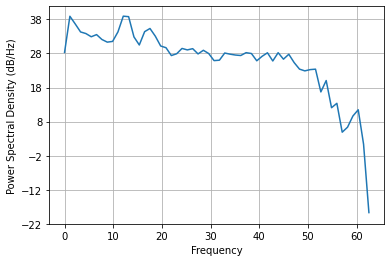

In [115]:
plt.psd(S1.data_chns['eeg_channel_7'], NFFT=int(len(S1.data_chns['eeg_channel_7'])/10), Fs=S1.fs)

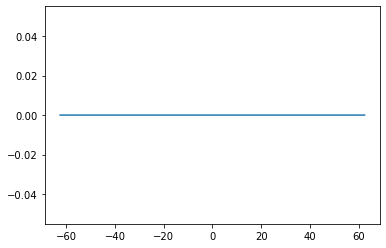

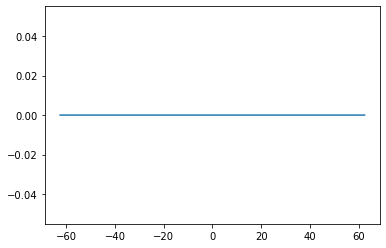

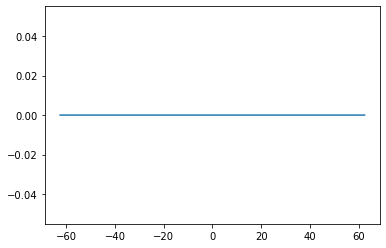

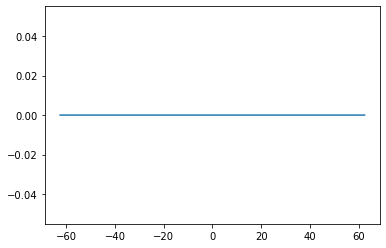

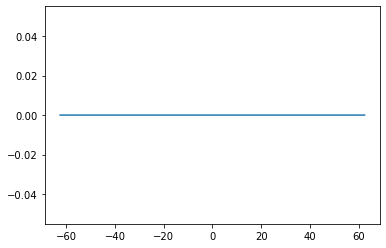

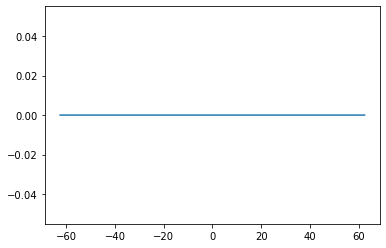

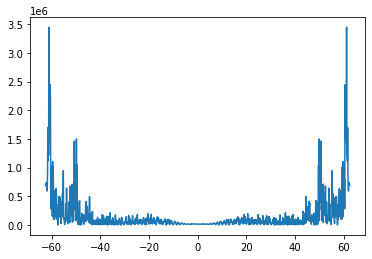

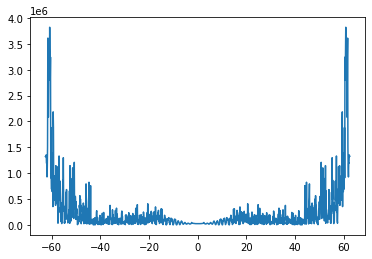

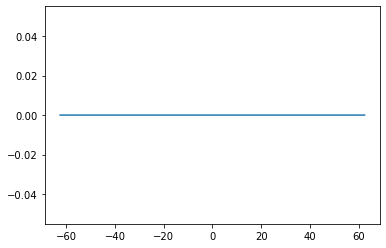

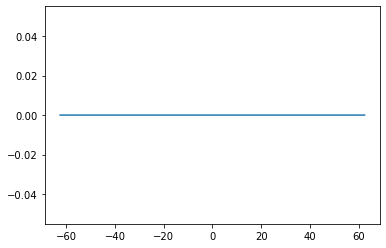

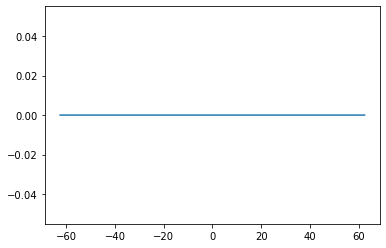

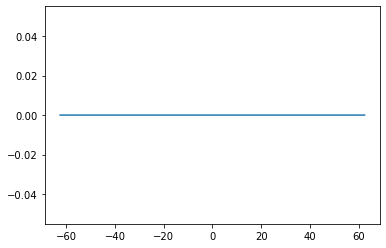

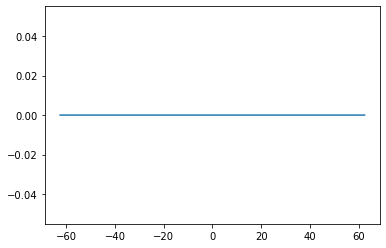

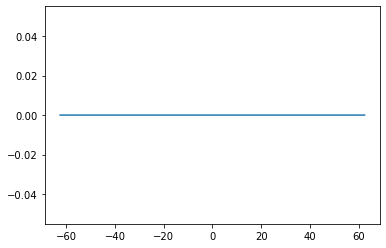

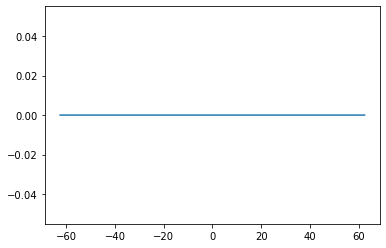

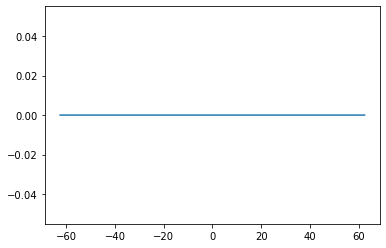

In [400]:
# plot
S1.plot(ver='fq')

In [979]:
S1.data_chns

,Time,eeg_channel_1,eeg_channel_2,eeg_channel_3,eeg_channel_4,eeg_channel_5,eeg_channel_6,eeg_channel_7,eeg_channel_8,eeg_channel_9,eeg_channel_10,eeg_channel_11,eeg_channel_12,eeg_channel_13,eeg_channel_14,eeg_channel_15,eeg_channel_16
125,1.000,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,-60.624460,-44.798192,9.313226e-10,9.313226e-10,9.313226e-10,1.033976e-25,1.033976e-25,9.313226e-10,9.313226e-10,9.313226e-10
126,1.008,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,3401.469577,4679.002222,-9.313226e-10,-9.313226e-10,-9.313226e-10,1.033976e-25,1.033976e-25,-9.313226e-10,-9.313226e-10,-9.313226e-10
127,1.016,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,1439.618950,2220.867182,9.313226e-10,9.313226e-10,9.313226e-10,1.033976e-25,1.033976e-25,9.313226e-10,9.313226e-10,9.313226e-10
128,1.024,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,-9.313226e-10,2515.763191,3275.544494,-9.313226e-10,-9.313226e-10,-9.313226e-10,1.033976e-25,1.033976e-25,-9.313226e-10,-9.313226e-10,-9.313226e-10
129,1.032,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,9.313226e-10,2494.404531,3045.928836,9.313226e-10,9.313226e-10,9.313226e-10,1.033976e-25,1.033976e-25,9.313226e-10,9.313226e-10,9.313226e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,10.080,7.025950e-10,7.025950e-10,7.025950e-10,7.025950e-10,7.025950e-10,7.025950e-10,-1188.225501,-1951.975265,7.025950e-10,7.025950e-10,7.025950e-10,1.033976e-25,1.033976e-25,7.025950e-10,7.025950e-10,7.025950e-10
1261,10.088,2.719629e-09,2.719629e-09,2.719629e-09,2.719629e-09,2.719629e-09,2.719629e-09,-1154.833707,-1871.219954,2.719629e-09,2.719629e-09,2.719629e-09,1.033976e-25,1.033976e-25,2.719629e-09,2.719629e-09,2.719629e-09
1262,10.096,1.018063e-09,1.018063e-09,1.018063e-09,1.018063e-09,1.018063e-09,1.018063e-09,-1237.490385,-1827.559693,1.018063e-09,1.018063e-09,1.018063e-09,1.033976e-25,1.033976e-25,1.018063e-09,1.018063e-09,1.018063e-09
1263,10.104,3.048549e-09,3.048549e-09,3.048549e-09,3.048549e-09,3.048549e-09,3.048549e-09,-2046.872184,-3098.307538,3.048549e-09,3.048549e-09,3.048549e-09,1.033976e-25,1.033976e-25,3.048549e-09,3.048549e-09,3.048549e-09
